**Taken from https://www.kaggle.com/abhishekmamidi/time-series-analysis-artificial-neural-networks/notebook**

## Download data, import libraries

In [ ]:
!pip install kaggle

In [ ]:
# Upload your kaggle api key
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!rm -r data/
!mkdir data/

In [ ]:
!kaggle datasets download -d abhishekmamidi/precipitation-data-of-pune-from-1965-to-2002
!unzip precipitation-data-of-pune-from-1965-to-2002.zip
!mv precipitation-data-of-pune-from-1965-to-2002.zip data/
!mv pune_1965_to_2002.csv data/

  0% 0.00/1.71k [00:00<?, ?B/s]
100% 1.71k/1.71k [00:00<00:00, 2.59MB/s]
Archive:  precipitation-data-of-pune-from-1965-to-2002.zip
  inflating: pune_1965_to_2002.csv   


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.callbacks import History 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import math
import itertools
import warnings
warnings.filterwarnings('ignore')
import pdb

## Analyze Data

In [ ]:
df = pd.read_csv("./data/pune_1965_to_2002.csv")

In [ ]:
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1,1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
2,1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
3,1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
4,1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


In [ ]:
df.set_index("Year", inplace=True)
df = df.transpose()
df

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.061,0.000,0.008,2.257,0.000,0.395,0.000,0.025,0.000,3.013,0.000,0.008,0.004,0.004,0.000,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,0.585,0.000,2.981,4.197,0.386,0.000,2.121,0.560,0.000,0.391,0.000,1.229,8.410,0.000,0.000,0.531,0.071,0.000,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,0.000,5.993,3.289,4.004,3.343,8.329,0.445,0.000,0.000,5.772,0.922,0.000,1.367,0.000,9.619,0.789,0.972,0.000,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,0.061,4.454,4.432,44.623,0.126,28.764,10.817,14.585,0.061,4.997,11.512,4.567,3.864,43.570,20.774,0.274,27.964,3.165,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,30.651,3.577,32.130,52.950,6.860,4.816,17.193,50.468,1.056,0.508,6.458,22.547,80.539,12.862,20.176,78.384,30.405,9.580,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,359.369,773.737,319.716,403.860,342.324,349.975,360.788,145.343,225.847,367.058,234.930,635.977,200.950,186.431,425.984,423.314,565.900,227.180,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,474.143,545.379,407.246,192.399,403.925,344.268,507.155,186.691,390.041,621.607,325.191,202.570,172.864,740.613,484.451,583.557,479.719,321.551,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,404.372,436.912,129.678,239.066,451.153,404.191,217.037,194.307,537.764,138.006,297.802,247.395,477.113,211.781,177.257,451.707,193.423,428.764,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,400.001,108.459,89.150,139.119,440.381,94.127,361.165,239.402,428.050,229.276,88.877,105.095,44.574,613.522,236.803,69.182,178.727,287.582,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,105.560,13.611,83.193,26.711,19.084,10.826,80.018,49.257,30.771,167.164,139.919,3.746,150.179,12.375,23.424,115.349,4.135,40.079,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


In [ ]:
dates = pd.date_range(start="1965-01", freq="MS", periods=len(df.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

Text(0.5, 1.0, 'Month vs Precipitation In Pune')

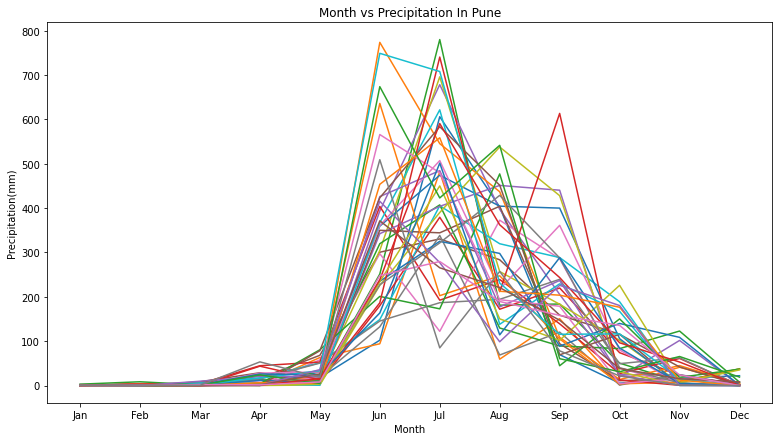

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(df)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation In Pune')

Text(0.5, 1.0, 'Month vs Precipitation In Pune')

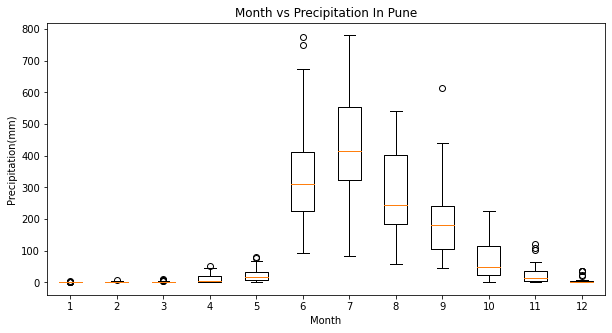

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot(df)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation In Pune')

In [ ]:
np_df = df.transpose().values
shape = np_df.shape
rain_data_by_month = np_df.reshape((shape[0] * shape[1]), 1)
rain_data_by_month[:10]

array([[2.90000e-02],
       [6.90000e-02],
       [0.00000e+00],
       [2.16670e+01],
       [1.78590e+01],
       [1.02111e+02],
       [6.06071e+02],
       [4.02521e+02],
       [6.95110e+01],
       [5.24900e+00]])

In [ ]:
rain_data_by_month_df = pd.DataFrame({"Precipitation": rain_data_by_month[:,0]})
rain_data_by_month_df.set_index(dates, inplace=True)
rain_data_by_month_df.shape

(456, 1)

We have 38 years (by month) of rain data. We can use the last 8 years as the test data and the first 30 as training data

In [ ]:
train_years = 30

In [ ]:
train_data = rain_data_by_month_df[:train_years*12]
test_data = rain_data_by_month_df[train_years*12:]
print(f"Test data shape: {test_data.shape}\nTraining data shape: {train_data.shape}")

Test data shape: (96, 1)
Training data shape: (360, 1)


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

## Neural Net Utils

In [ ]:
def print_loss(model, epoch_range):
  history = model.history.history["loss"]
  for i, loss in enumerate(history):
    if (i) % epoch_range == 0:
      print(f"Loss for epoch {i}:\t {loss}")
  print(f"Loss for epoch {epochs}:\t {history[-1]}")

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [ ]:
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [ ]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [ ]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

## Create the Neural Net Class

In [ ]:
class NN:

  def run_NN(self, data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    pass

  def preprocess(self, data, look_back):
    pass

  def predict(self, input_sequence, future_steps):
    pass

  def train(self, X_train, Y_train, num_epochs, batch_size, verbose=False):
      self.model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, callbacks=[self.history], verbose=0)

  def get_accuracy(self, train_data, train_labels, parameters, scaler):
    pass

## Regular NN

In [ ]:
# Regular Feed Forward NN With 1 hidden layer
class NN_1(NN):

  def __init__(self, input_nodes, hidden_nodes):
    model = Sequential(name="NN_1")
    model.add(Dense(hidden_nodes, input_dim=int(input_nodes), activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss="mean_squared_error", optimizer="adam")
    self.history = History()
    self.model = model

  def preprocess(self, data, look_back):
    # pdb.set_trace()
    data = np.array(data)[:,0]
    X_train = []
    Y_train = []
    for i in range(data.shape[0] - look_back):
      x = data[i:look_back+i][::-1]
      y = data[look_back+i]
      X_train.append(list(x))
      Y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    X_train, Y_train = reshape_arrays(X_train, Y_train)
    return X_train, Y_train, input_seq_for_test

  def predict(self, input_sequence, future_steps):
    predictions = []
    for i in range(future_steps):
      prediction = self.model.predict(input_sequence)
      predictions.append(prediction[0][0])
      input_sequence[0] = np.append(prediction, input_sequence[0][:-1])
    return predictions

  def run_NN(self, data, look_back, hidden_nodes, output_nodes, num_epochs, batch_size, future_steps, scaler):
    # pdb.set_trace()
    data = scaler.transform(data)
    X_train, Y_train, input_seq_for_test = self.preprocess(data, look_back)
    self.train(X_train, Y_train, num_epochs, batch_size)
    input_seq_for_test = np.reshape(input_seq_for_test, (1, len(input_seq_for_test)))
    predictions = self.predict(input_sequence=input_seq_for_test, future_steps=future_steps)
    predictions = list(scaler.inverse_transform([predictions])[0])
    return predictions

  def get_accuracy(self, train_data, test_data, params, scaler):
    look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps = params
    predictions = self.run_NN(train_data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
    y_true = test_data.Precipitation
    mse, mae, mape, rmse = calculate_performance(y_true, predictions)
    info = list(param) + [mse, mae, rmse] + predictions
    return info
    

In [ ]:
input_nodes = 5
look_back = input_nodes
hidden_nodes = 3
future_steps = 96
epochs = 500
batch_size = 20
# input_nodes, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_NN1 = [[1,2,3,6,8,10,12], [3,4,5,6], [1], [500], [20], [future_steps]]

In [ ]:
nn_1 = NN_1(input_nodes, hidden_nodes)
nn_1.model.summary()
X_train, Y_train, input_seq_for_test = nn_1.preprocess(scaler.transform(train_data), look_back)

Model: "NN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn_1.train(X_train, Y_train, epochs, batch_size)

In [ ]:
print_loss(nn_1.model, 100)

Loss for epoch 0:	 0.08816099911928177
Loss for epoch 100:	 0.02543681487441063
Loss for epoch 200:	 0.02165602520108223
Loss for epoch 300:	 0.020190531387925148
Loss for epoch 400:	 0.019431786611676216
Loss for epoch 500:	 0.01895442232489586


In [ ]:
input_seq_for_test = np.reshape(input_seq_for_test, (1, len(input_seq_for_test)))

In [ ]:
input_seq_for_test

array([[0.        , 0.01807422, 0.14916296, 0.14808732, 0.2960208 ]])

In [ ]:
nn_1.model.predict(input_seq_for_test)

array([[0.]], dtype=float32)

In [ ]:
params = get_combinations(parameters_NN1)
nn_info = []
print('NN_1 - Number of combinations: ' + str(len(params)))
for param in params:
  print(f"Using parameters {param}")  
  input_nodes, hidden_nodes, _, _, _, _ = param
  nn_temp = NN_1(input_nodes, hidden_nodes)
  info = nn_temp.get_accuracy(train_data, test_data, param, scaler)
  print(info)
  nn_info.append(info)
  
nn_info_df = pd.DataFrame(nn_info)
indexes = [str(i) for i in list(range(1, future_steps+1))]
nn_info_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes

NN_1 - Number of combinations: 28
Using parameters (1, 3, 1, 500, 20, 96)
[1, 3, 1, 500, 20, 96, 39065.972, 111.343, 197.651, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Using parameters (1, 4, 1, 500, 20, 96)
[1, 4, 1, 500, 20, 96, 39065.972, 111.343, 197.651, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.